In [1]:
# Підключення необхідних бібліотек
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

In [2]:
# Завантаження тестового та тренувального датасетів
def load_dataset():
	# Завантаження датасету
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# Змінити набір даних, щоб мати єдиний канал
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [3]:
# Масштабування пікселів
def prep_pixels(train, test):
	# Конвертувати з цілих чисел у плаваючі
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# Нормалізувати до діапазону 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# Повернути нормалізовані зображення
	return train_norm, test_norm

In [4]:
# визначити модель cnn
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# Компілювати модель
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [5]:
# Завантажити датасет
trainX, trainY, testX, testY = load_dataset()
# Підготувати піксельні дані
trainX, testX = prep_pixels(trainX, testX)
# Визначити модель
model = define_model()
# Навчити модель
model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=1)
# Зберегти модель
model.save('final_model.h5')

C:\Users\bodya\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/10
1875/1875 [==============================] - 33s 5ms/step - loss: 0.1329 - accuracy: 0.9592
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0455 - accuracy: 0.9858
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0294 - accuracy: 0.9908
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0215 - accuracy: 0.9931
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0168 - accuracy: 0.9944
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0129 - accuracy: 0.9958
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0096 - accuracy: 0.9970
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - 

In [6]:
# Оцінка моделі
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))

> 98.830


In [7]:
# Оцінити модель, використовуючи k-кратну перехресну перевірку
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# Підготувати перехресну перевірку
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		model = define_model()
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		history = model.fit(trainX, trainY, epochs=3, batch_size=64, validation_data=(testX, testY), verbose=0)
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# Зберегти оцінку
		scores.append(acc)
		histories.append(history)
	return scores, histories
 
# Побудова діагностичних кривих навчання
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# Втрати
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# Точність
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()
 
# Підвести підсумки роботи моделі
def summarize_performance(scores):
	# Вивести підсумки
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	pyplot.boxplot(scores)
	pyplot.show()

> 99.075
> 98.900
> 98.817
> 99.192
> 98.950


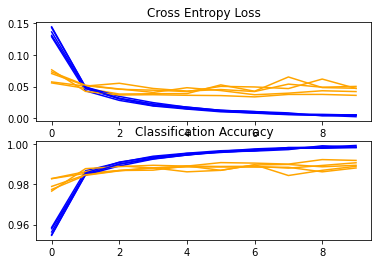

Accuracy: mean=98.987 std=0.132, n=5


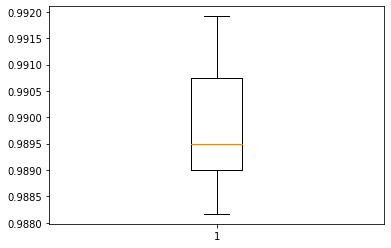

In [8]:
# Оцінити модель
scores, histories = evaluate_model(trainX, trainY)
# Криві навчання
summarize_diagnostics(histories)
# Вивести загальну оцінку 
summarize_performance(scores)

In [9]:
# Перевірка завантаженого зображення
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# Завантаження та форматування картинки
def load_image(filename):
	img = load_img(filename, grayscale=True, target_size=(28, 28))
	img = img_to_array(img)
	img = img.reshape(1, 28, 28, 1)
	img = img.astype('float32')
	img = img / 255.0
	return img

In [84]:
img = load_image('sample_image.png')
model = load_model('final_model.h5')
# Прогнозувати клас
digit = model.predict_classes(img)
print(digit[0])

7
